In [1]:
import torch

def fun(X):
    N,dim=X.size()
    y=torch.zeros(N)
    for i in range(0,N):
        Xi=torch.cos(X[i,:])*torch.cos(X[i,:])
        y[i]=torch.dot(Xi.t()-1,Xi-1)+1
    return y

## Generate a Graph

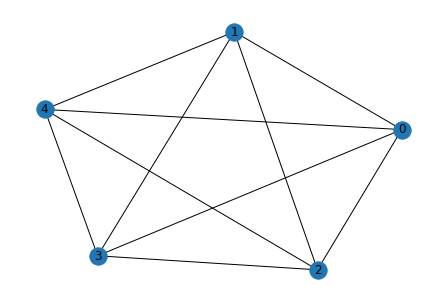

In [2]:
import networkx as nx
from rff import GaussianRff
import numpy as np
import torch
import copy
is_communication=True
num_nodes=5
num_init=5
N_per_node=100
N=int(N_per_node*num_nodes)
batch=1
# simple node information
dim=1
D=20
gamma=1
# generate a graph
# G=nx.barabasi_albert_graph (num_nodes,num_init)
G=nx.complete_graph (num_nodes)

net=torch.nn.Linear(D,1,bias=False)
kernel=GaussianRff(dim,gamma,net,D)
kernel.net.weight.data=kernel.theta.unsqueeze(0)

for v in range(0,num_nodes):
    kernel_v=copy.deepcopy(kernel)# copy.deepcopy is neccessary to prevent objects from being the only one
    G.nodes[v].update({'index':v,'learner':kernel_v})
    G.nodes[v].update({'send_info':[]})  #kernel.theta#send infomation to other nodes
    G.nodes[v].update({'recev_info':[]})
    G.nodes[v].update({'batch':batch})
    # print(G.nodes[v]['index'])

    # G.nodes[v].update({'para':{'theta':kernel.theta,'grad':kernel.grad}})
pos = nx.spring_layout(G)
nx.draw(G,pos)
node_labels=nx.get_node_attributes(G,'index')
nx.draw_networkx_labels(G,pos,labels=node_labels)
# generete dataset
n_split=np.zeros(num_nodes)+N/num_nodes
for v in range(0,num_nodes):
    x=torch.randn(int(n_split[v]),dim)
    y=fun(x)
    data_split={'x':x,'y':y}
    G.nodes[v].update({'data':data_split})# data -> local nodes 
    # print(G.nodes[i]['data'])
# G.degree(1) number of degree
min_N=int(min(n_split))
######
#######
# grad=torch.zeros(1,kernel.D)
T=min_N/batch
from matplotlib import pyplot as plt
plt.savefig('figs/sk/D_N_{}_Sk_G_it_{}_b_{}_D_{}_com_{}.png'.format(num_nodes,int(T),batch,D,is_communication),dpi=600)


## Create Graph Learning Framework

In [3]:
from decentralize_fk_3_0 import GraphLearning

GL=GraphLearning(G)

In [4]:
import torch.nn.functional as F
# loss=F.mse_loss(yhat, yt)
testN=100
testX=torch.randn(testN,dim)+1
testY=fun(testX)
#########################       MSE         ##################################
T=int(T)
rff_mse_T=torch.zeros(num_nodes,T)#record performance of MK by MSE 
##################################################

In [5]:
GL.GLearning(T)

Glearning start!
node 4: train is over!!!!!!!!!
node 1: train is over!!!!!!!!!

node 3: train is over!!!!!!!!!
node 0: train is over!!!!!!!!!

node 2: train is over!!!!!!!!!





In [8]:
rff_mse_T=torch.zeros(num_nodes,T)
for t in range(0,T):
    for v in range(0,num_nodes):
        # print(GL.graph.nodes[v]['para'][t]['up_para']['theta'])
        thetav=GL.graph.nodes[v]['para'][t]['up_para']['theta']
        GL.graph.nodes[v]['learner'].theta=torch.from_numpy(thetav)
        # print(thetav)
        rff_v_ypre_t=GL.graph.nodes[v]['learner'].Fit(testX)
        rff_v_mse_t=F.mse_loss(rff_v_ypre_t,testY)
        print('vex_{},time {},loss={}'.format(v,t,rff_v_mse_t))
        rff_mse_T[v,t]=rff_v_mse_t


vex_0,time 0,loss=1.5381109714508057
vex_1,time 0,loss=1.5381109714508057
vex_2,time 0,loss=1.5381109714508057
vex_3,time 0,loss=1.5381109714508057
vex_4,time 0,loss=1.5381109714508057
vex_0,time 1,loss=1.1919806003570557
vex_1,time 1,loss=1.1919806003570557
vex_2,time 1,loss=1.1919806003570557
vex_3,time 1,loss=1.1919806003570557
vex_4,time 1,loss=1.1919806003570557
vex_0,time 2,loss=0.9620341658592224
vex_1,time 2,loss=0.9620341658592224
vex_2,time 2,loss=0.9620341658592224
vex_3,time 2,loss=0.9620341658592224
vex_4,time 2,loss=0.9620341658592224
vex_0,time 3,loss=0.6921392679214478
vex_1,time 3,loss=0.6921392679214478
vex_2,time 3,loss=0.6921394467353821
vex_3,time 3,loss=0.6921393871307373
vex_4,time 3,loss=0.6921392679214478
vex_0,time 4,loss=0.5891451239585876
vex_1,time 4,loss=0.5891451239585876
vex_2,time 4,loss=0.5891451835632324
vex_3,time 4,loss=0.5891451835632324
vex_4,time 4,loss=0.5891451835632324
vex_0,time 5,loss=0.4810263514518738
vex_1,time 5,loss=0.48102638125419617


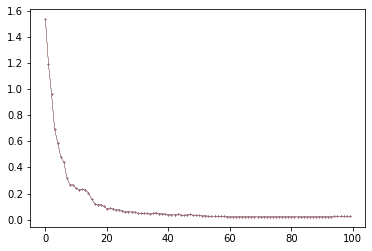

In [9]:
################ MSE plot ####################
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
colors=list(mcolors.TABLEAU_COLORS.keys())
plt.figure(0)
for v in range(0,num_nodes):
    plt.plot(range(0,rff_mse_T.shape[1]),rff_mse_T[v,:],'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[v]])
# plt.savefig('figs/sk/D_N_{}_Sk_E_it_{}_b_{}_D_{}_com_{}.png'.format(num_nodes,int(T),batch,D,is_communication),dpi=600)
